In [1]:
from scipy.io import loadmat
import numpy as np
import mne
import matplotlib.pyplot as plt

EEG.shape: (1, 1)
eeg_data.shape: (64, 640, 99)
times.shape: (640,)


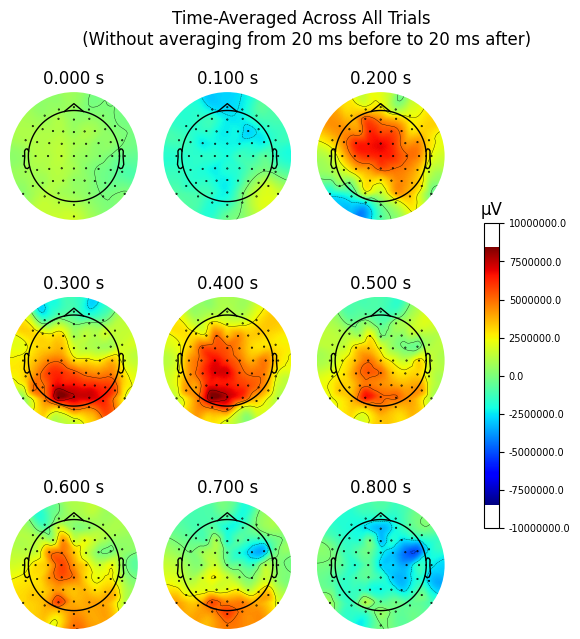

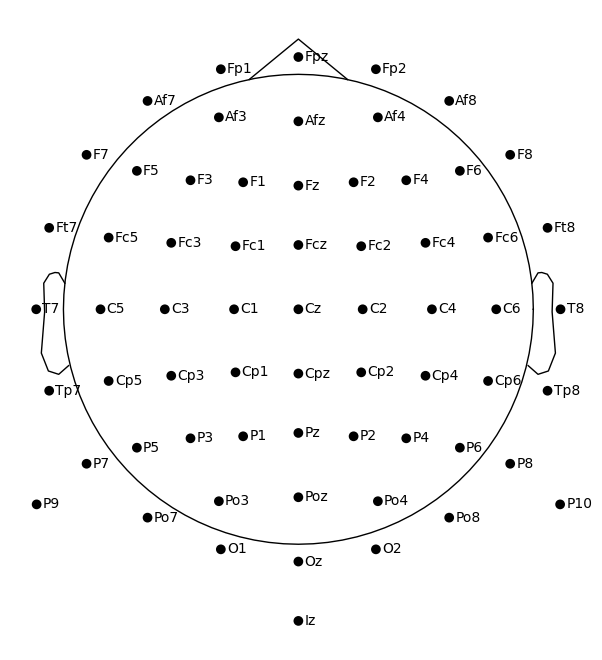

C:\Users\tnlab\AppData\Local\Temp\ipykernel_9864\3022459550.py:77: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.evoked.EvokedArray'>.tmin (0 s)
  avg_data = evoked_20.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)


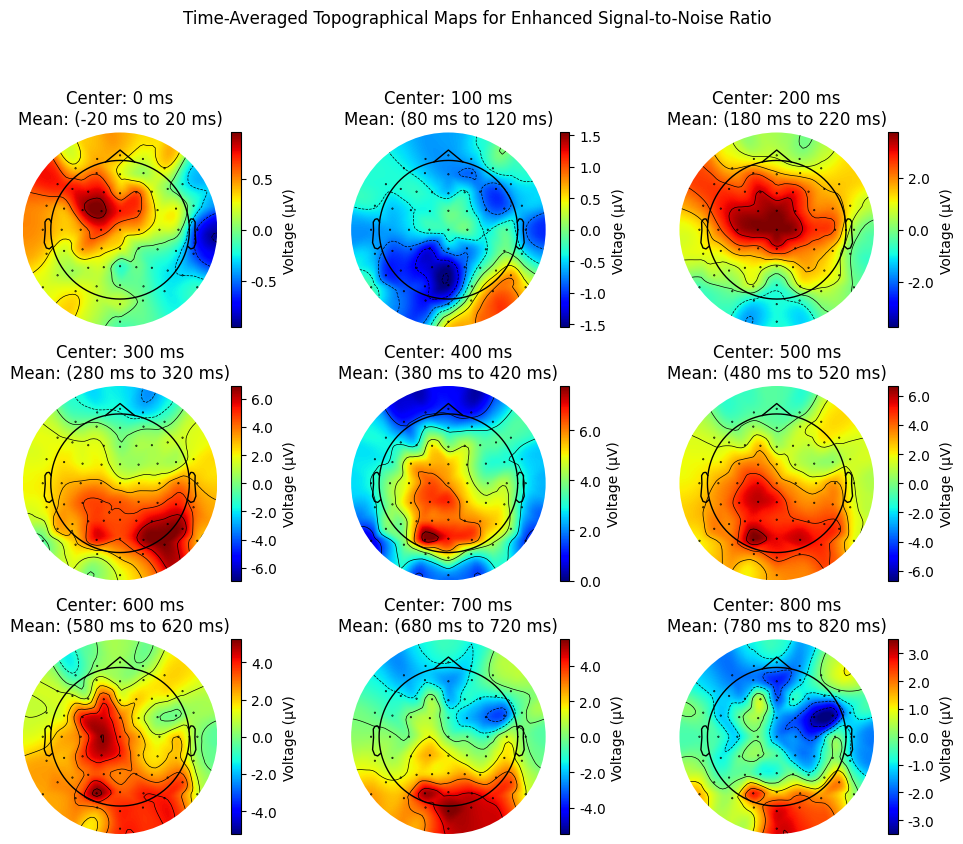

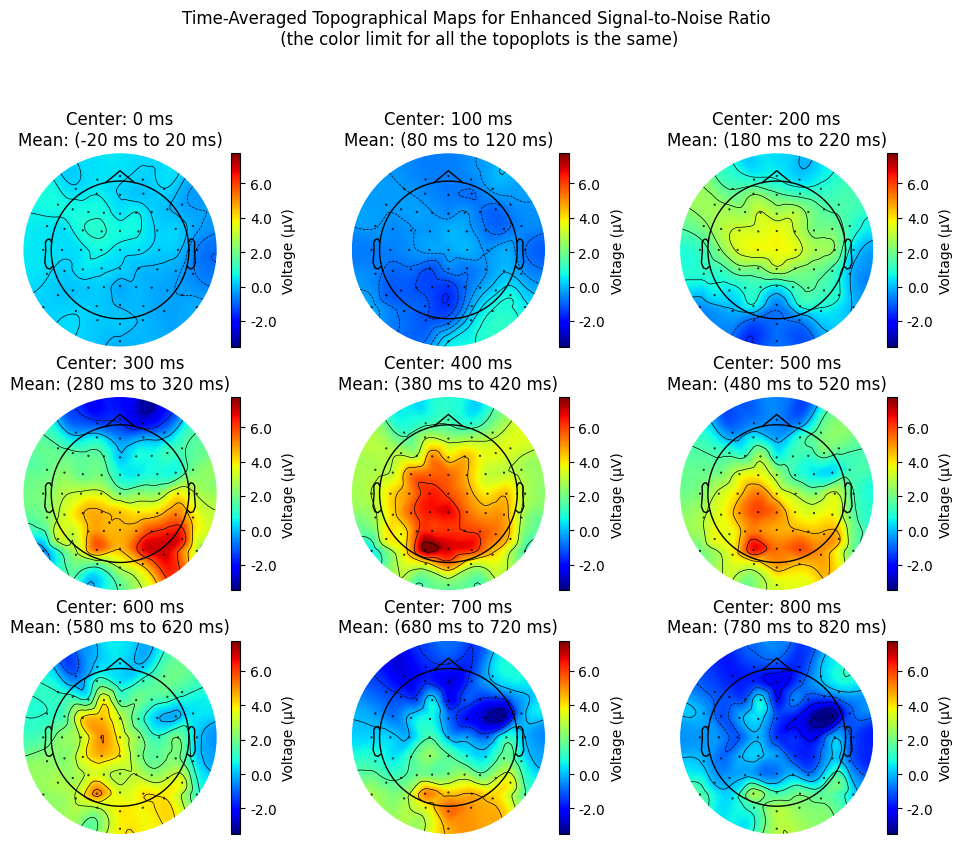

In [2]:
# 1. Load the .mat file
data = loadmat('sampleEEGdata.mat')
EEG = data['EEG']
eeg_data = EEG['data'][0, 0] #eeg_data.shape=(64, 640, 99), [channels:64, time points:640, trials:99]
times = EEG['times'][0, 0][0] #times.shape= (640,)
print('EEG.shape:', EEG.shape) #EEG.shape: (1, 1)
print('eeg_data.shape:', eeg_data.shape) #EEG.shape: (1, 1)
print('times.shape:', times.shape) #EEG.shape: (1, 1)
microvolt = "µV"

######################################################################################################################################################
# a.1. Extract Epochs from 0 to 800 ms
# Given a sampling rate of 256 Hz, the time interval between two consecutive samples is 1/256 = 3.90625 ms. (I consider 4ms for each sample point)
# Thus, 0 ms corresponds to the sample point at index 256, 
# and 800 ms corresponds to the sample point at index (800 / 3.90625) = 256+204.8=460.8, which can be rounded to 461.
eeg_data_epoch= eeg_data[:, 256:462, :]# eeg_data_epoch.shape: (64, 206, 99), 256:462:
#This indexes elements from the 256th to the 461st along the second dimension(since Python indexing is 0-based and the stop value in a slice is exclusive).
eeg_data_epoch_20= eeg_data[:, 251:467, :] # eeg_data_epoch_20.shape:(64, 216, 99), adding the sample point (-20,0) and (800,820) to my epoch.
# print('eeg_data_epoch.shape:', eeg_data_epoch.shape, 'eeg_data_epoch_20.shape', eeg_data_epoch_20.shape )
# Compute the ERP at each electrode by averaging across all trials
ERP = np.mean(eeg_data_epoch, axis=2) # shape: (64, 206)
ERP_20 = np.mean(eeg_data_epoch_20, axis=2) # shape: (64, 216)

################################################################
# Read the file content
with open('eloc64C2.txt', 'r') as f:
    lines = f.readlines()
# Extract channel names, theta, and radius
channel_names = [line.split()[3].replace('.', '') for line in lines[0:]]  # Skip the header
theta = np.array([float(line.split()[1])-90 for line in lines[0:]]) * np.pi / 180.0  # Convert to radians
radius = np.array([float(line.split()[2]) for line in lines[0:]])
# Convert polar to Cartesian
x = radius * np.cos(theta)/5
y = -radius * np.sin(theta)/5
z = np.zeros_like(x)  # default z-coordinate for all channels
# Create a montage
ch_pos = dict(zip(channel_names, zip(x, y, z)))
montage = mne.channels.make_dig_montage(ch_pos, coord_frame='head')
info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
# Apply the montage to the info
info.set_montage(montage)

##########################
# Create an evoked object
# The evoked object is an instance of the EvokedArray class in MNE, which is useful for visualization and further processing in the MNE ecosystem.
#ERP: It is a 2D numpy array that contains the event-related potential values. This is a simple numeric representation with dimensions corresponding to channels and time points.
#evoked: It is an object of type EvokedArray that wraps around the ERP numpy array. It integrates the numeric ERP data with metadata (info)
#and provides various methods and attributes for easier visualization and analysis of the data in the context of the MNE-Python library. 
evoked = mne.EvokedArray(ERP, info)
evoked_20 = mne.EvokedArray(ERP_20, info)

###############################################
# a.2. Plot the topographical map
# The evoked.plot_topomap() function from the MNE-Python library is used to plot topographical maps of EEG data, 
# giving a spatial representation of voltage (or other measures) across the scalp at specific points in time.
evoked.plot_topomap(times=np.linspace(0, .8, 9), nrows=3, ncols=3, size=1, cmap='jet', time_unit='s', show=False)
plt.suptitle("Time-Averaged Across All Trials \n (Without averaging from 20 ms before to 20 ms after)", y=1.05)
plt.show()

##########
# Plot the sensor locations
# When you're plotting EEG channels with plot_sensors, MNE sometimes creates two plots: one for a top-down view and another for a side view,
# especially when 3D channel locations (with both horizontal and vertical coordinates) are present.
# You can suppress the side view by setting the proj argument to True:
evoked.plot_sensors(kind='topomap', show_names=True, ch_type='eeg')

#######################################################################
# a. Time-Averaged Topographical Maps for Enhanced Signal-to-Noise Ratio
plt.close('all')
center_times = np.linspace(0, .8, 9)  # 0ms, 100ms, ..., 800ms
fig, axs = plt.subplots(3, 3, figsize=(10,8))
fig.suptitle("Time-Averaged Topographical Maps for Enhanced Signal-to-Noise Ratio", fontsize=12, y=1.05)
AVE_ERP=[]
for idx, center_time in enumerate(center_times):
    start_time = center_time - 0.020
    end_time = center_time + 0.020
    avg_data = evoked_20.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)
    AVE_ERP.append(avg_data)
    ax = axs[idx // 3, idx % 3]
    im, _ = mne.viz.plot_topomap(avg_data, evoked_20.info, cmap='jet', axes=ax, show=False)
    fig.colorbar(im, ax=ax, format='%3.1f', orientation='vertical', label='Voltage (µV)') 
    ax.set_title(f"Center: {center_time*1000:.0f} ms\nMean: ({start_time*1000:.0f} ms to {end_time*1000:.0f} ms)")
plt.tight_layout()
plt.show()
AVE_ERP_np=np.array(AVE_ERP)
# print('AVE_ERP_np.shape', AVE_ERP_np.shape) #(9,64)

########################################################
# Making the color limit for all the topoplots the same
plt.close('all')
center_times = np.linspace(0, .8, 9)  # 0ms, 100ms, ..., 800ms
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
fig.suptitle("Time-Averaged Topographical Maps for Enhanced Signal-to-Noise Ratio\n (the color limit for all the topoplots is the same)", fontsize=12, y=1.05)
global_vmin, global_vmax = AVE_ERP_np.min(), AVE_ERP_np.max()
for idx, center_time in enumerate(center_times):
    start_time = center_time - 0.020
    end_time = center_time + 0.020
    ax = axs[idx // 3, idx % 3]
    im, _ = mne.viz.plot_topomap(AVE_ERP_np[idx, :], evoked_20.info, cmap='jet', axes=ax, show=False)
    # Adjust the color limits to reflect the global max and min
    im.set_clim(global_vmin, global_vmax)
    fig.colorbar(im, ax=ax, format='%3.1f', orientation='vertical', label='Voltage (µV)')
    ax.set_title(f"Center: {center_time*1000:.0f} ms\nMean: ({start_time*1000:.0f} ms to {end_time*1000:.0f} ms)")
plt.tight_layout()
plt.show()
# print('AVE_ERP_np.shape', AVE_ERP_np.shape)  # (9, 64)

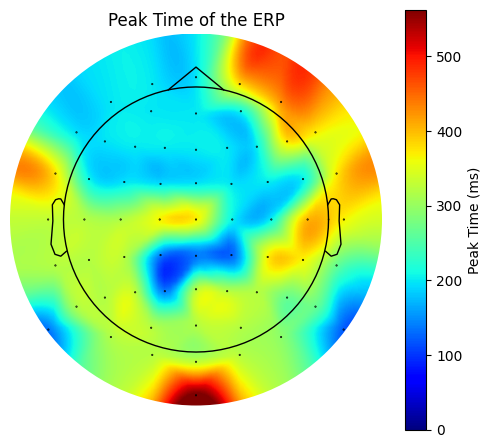

In [291]:
# b. 
times = evoked.times
# print('times:', times, 'times.shape', times.shape) # [0.         0.00390625, ..., 0.80078125], times.shape (206,)
max_values = []
max_times = []
for i in range(ERP.shape[0]):
    max_val = np.max(ERP[i, :])
    max_idx = np.argmax(ERP[i, :])
    max_values.append(max_val)
    max_times.append(times[max_idx])
max_values = np.array(max_values)
max_times = np.array(max_times) * 1000  # Convert to milliseconds

######################################################################
fig, ax = plt.subplots(figsize=(6,5))
im, _ = mne.viz.plot_topomap(max_times, evoked.info, cmap='jet', contours=0, axes=ax, show=False, size=3)
# Show colorbar
plt.colorbar(im, ax=ax, label='Peak Time (ms)')
plt.title("Peak Time of the ERP")
plt.show()


b. In the displayed figure, the color scheme indicates the timing of responses, where blue represents the earliest response and red represents the latest. Shades in between denote relative response timings based on their color intensity.
Upon examination, electrodes (Cpz, Cp2, Cp1, P1, P10, P9) exhibit the earliest response. This trend is also evident in the upper left section of the scalp. Conversely, electrodes like Iz, Fp2, Af8, and F8 show the latest response.
Additionally, below you can find the temporal average visualization for each electrode, presented separately

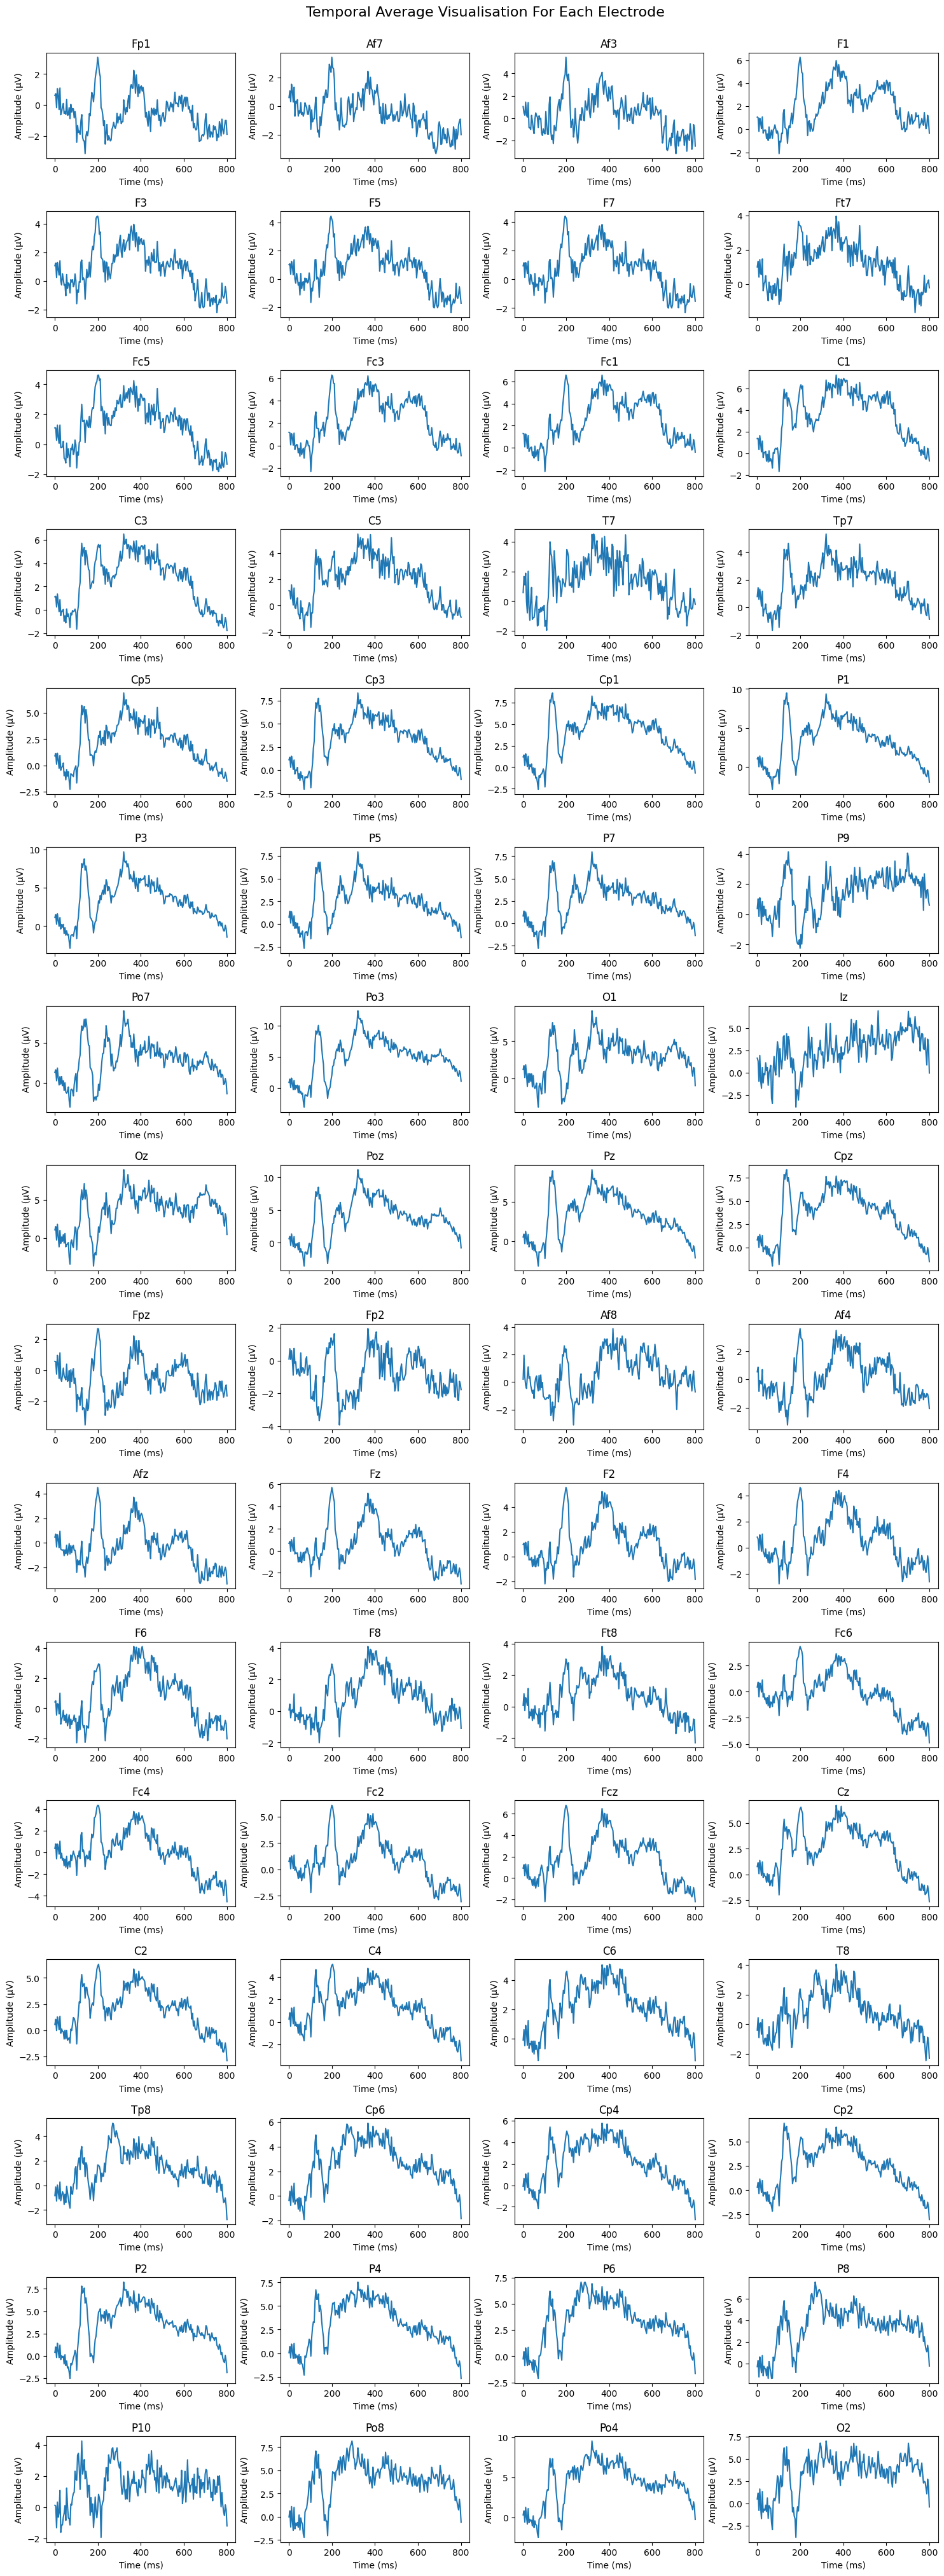

In [292]:
############
fig, axs = plt.subplots(nrows=16, ncols=4, figsize=(15, 40))
fig.tight_layout(pad=2.0)  # Adjust the spacing between subplots
fig.suptitle('Temporal Average Visualisation For Each Electrode', fontsize=16, y=1.01) 
# Flatten the axis array for easier indexing
axs = axs.ravel()
for idx in range(64):  # Loop through each channel
    # Plot the ERP data for the current channel over time
    axs[idx].plot(times * 1000, ERP[idx, :])
    axs[idx].set_title(evoked.ch_names[idx])  # Set title as channel name
    axs[idx].set_xlabel('Time (ms)')
    axs[idx].set_ylabel('Amplitude (µV)')
plt.subplots_adjust(hspace=0.5)
plt.show()

C:\Users\tnlab\AppData\Local\Temp\ipykernel_16184\2574989804.py:37: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.evoked.EvokedArray'>.tmin (0 s)
  avg_data_l = laplacian_raw.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)


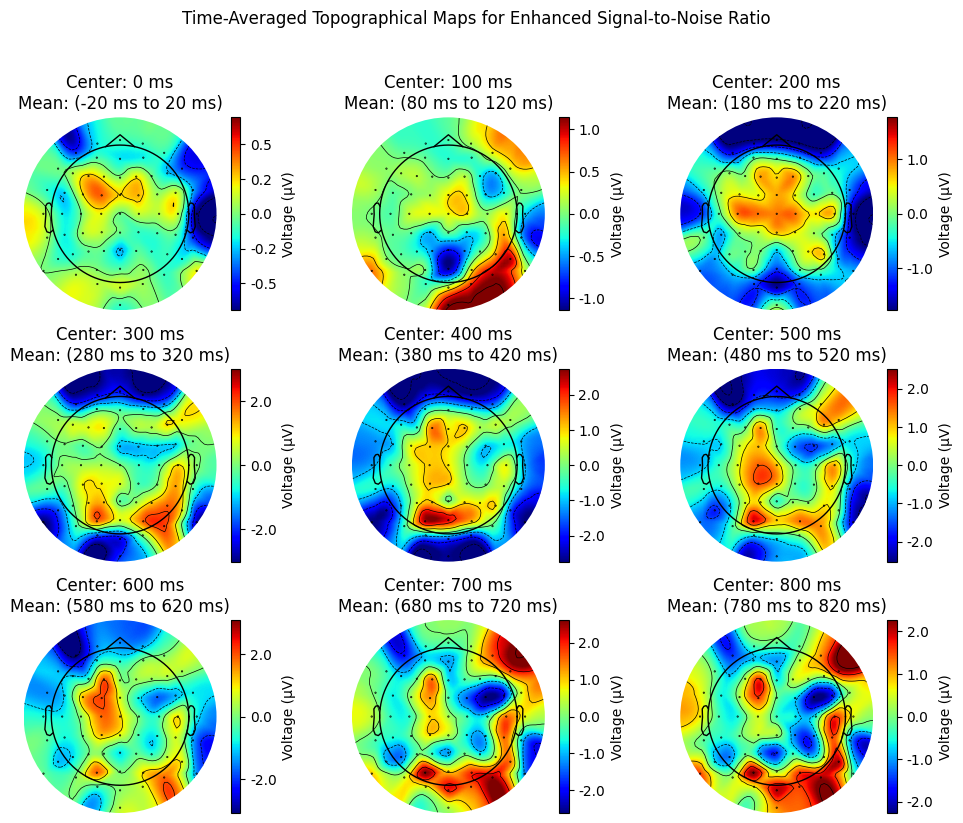

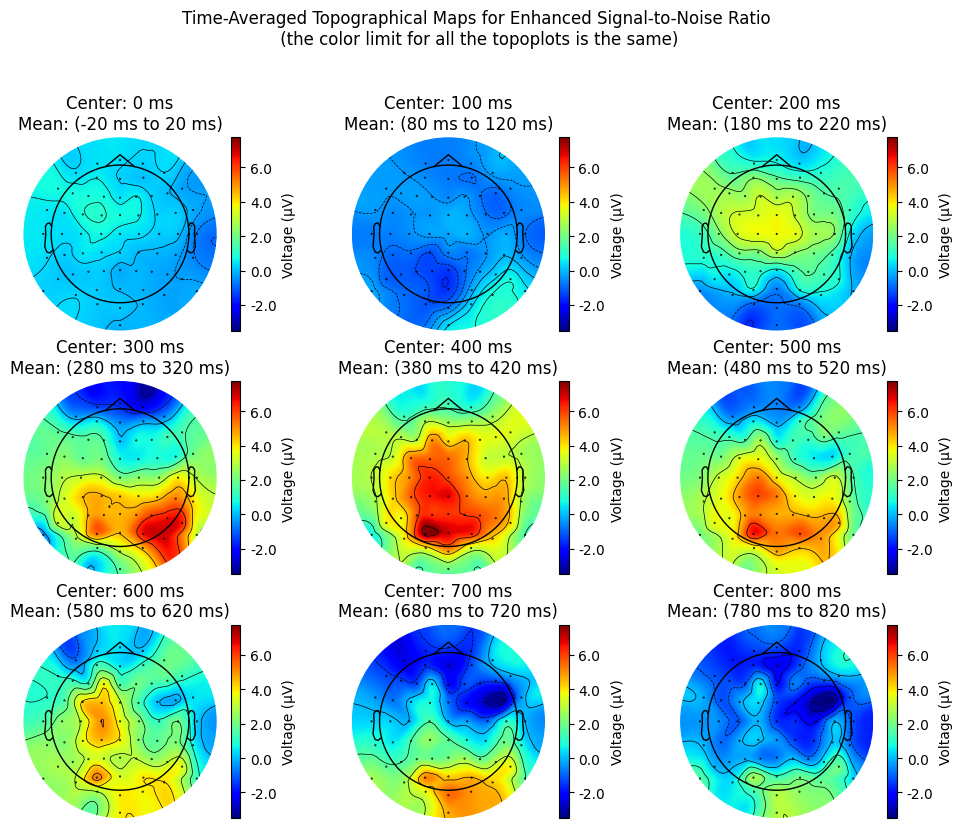

In [294]:
# c.
with open('eloc64C2.txt', 'r') as f_l:
    lines_l = f_l.readlines()
channel_names_l = [line_l.split()[3].replace('.', '') for line_l in lines_l[0:]] 
theta_l = np.array([float(line_l.split()[1]) for line_l in lines_l[0:]]) * np.pi / 180.0  
radius_l = np.array([float(line_l.split()[2]) for line_l in lines_l[0:]])
x_l = radius_l * np.cos(theta_l)
y_l = radius_l * np.sin(theta_l)
z_l = np.zeros_like(x_l)
radius_range = [0.18, 0.28]
laplacian_data = np.zeros_like(ERP_20)
for i in range(64):
    distances = np.sqrt((x_l - x_l[i]) ** 2 + (y_l - y_l[i]) ** 2)
    surrounding_indices = np.where((distances > radius_range[0]) & (distances < radius_range[1]))[0]
    if len(surrounding_indices) > 0:
        weights = 1 / distances[surrounding_indices]
        weights = weights / np.sum(weights)  # Normalize weights
    else:
        weights = np.array([])
    weights = weights[:, np.newaxis]
    if len(weights) > 0:
        laplacian_data[i, :] = ERP_20[i, :] - np.sum(weights * ERP_20[surrounding_indices, :], axis=0)
    else:
        laplacian_data[i, :] = ERP_20[i, :]
laplacian_raw = evoked_20.copy()
laplacian_raw._data = laplacian_data

########################################
plt.close('all')
center_times = np.linspace(0, .8, 9)  
fig, axs = plt.subplots(3, 3, figsize=(10,8))
fig.suptitle("Time-Averaged Topographical Maps for Enhanced Signal-to-Noise Ratio", fontsize=12, y=1.03)
AVE_ERP_l=[]
for idx, center_time in enumerate(center_times):
    start_time = center_time - 0.020
    end_time = center_time + 0.020
    avg_data_l = laplacian_raw.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)
    AVE_ERP_l.append(avg_data)
    ax = axs[idx // 3, idx % 3]
    im, _ = mne.viz.plot_topomap(avg_data_l, laplacian_raw.info, cmap='jet', axes=ax, show=False)
    fig.colorbar(im, ax=ax, format='%3.1f', orientation='vertical', label='Voltage (µV)') 
    ax.set_title(f"Center: {center_time*1000:.0f} ms\nMean: ({start_time*1000:.0f} ms to {end_time*1000:.0f} ms)")
plt.tight_layout()
plt.show()
AVE_ERP_np_l=np.array(AVE_ERP)

###################################################
plt.close('all')
center_times = np.linspace(0, .8, 9)  
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
fig.suptitle("Time-Averaged Topographical Maps for Enhanced Signal-to-Noise Ratio\n (the color limit for all the topoplots is the same)", fontsize=12, y=1.03)
global_vmin, global_vmax = AVE_ERP_np_l.min(), AVE_ERP_np_l.max()
for idx, center_time in enumerate(center_times):
    start_time = center_time - 0.020
    end_time = center_time + 0.020
    ax = axs[idx // 3, idx % 3]
    im, _ = mne.viz.plot_topomap(AVE_ERP_np_l[idx, :], laplacian_raw.info, cmap='jet', axes=ax, show=False)
    im.set_clim(global_vmin, global_vmax)
    fig.colorbar(im, ax=ax, format='%3.1f', orientation='vertical', label='Voltage (µV)')
    ax.set_title(f"Center: {center_time*1000:.0f} ms\nMean: ({start_time*1000:.0f} ms to {end_time*1000:.0f} ms)")
plt.tight_layout()
plt.show()

By implementing the large Laplacian filter, we significantly enhance the spatial precision of the EEG data. The Laplacian filter operates on the principle of spatial second derivatives, which emphasizes local changes in the signal. As a result, this technique sharpens the topographic representation of the electrical activity on the scalp, allowing for a more detailed and localized observation. When comparing the results from step (c) with those from step (a), it becomes evident that the Laplacian-filtered data provides a clearer distinction between active and non-active regions. This improved localization can be particularly beneficial in identifying focal brain activities and can aid in the interpretation of the underlying neural sources. Thus, the large Laplacian filter emerges as an essential tool for a more precise spatial analysis of EEG data